In [24]:
import os

import cv2 as cv
import numpy as np
import imutils
import tensorflow as tf
import pytesseract
from skimage.io import imshow
from doctr.models import crnn_vgg16_bn, crnn_mobilenet_v3_large
from inspection.support.utils import extract, align, cut

In [25]:
OCR_MASK_COLOR = np.array([255, 0, 0])


source_folder = (
    "/media/egor/T7/vut_dp_project_workspace/assets/datasets/custom_structured"
)
targets = [
    "34_drawcore_uc_16mm_f8_6448",
    "35_drawcore_uc_16mm_f8_5270",
    "36_drawcore_uc_16mm_f8_7604",
]

template_masked_dir = "./inspection/support/ocr/drawcore"
template_masked_original = cv.cvtColor(
    cv.imread("inspection/support/um_camera/drawcore.bmp"),
    cv.COLOR_RGB2GRAY,
)

extract_meta = {
    "100": [np.array([255, 0, 0], np.uint8), 180, True],  # RGB, rotate 180
    # RGB, rotate 180 (bad text)
    "010": [np.array([0, 255, 0], np.uint8), 180, False],
    "001": [np.array([0, 0, 255], np.uint8), 90, True],  # RGB, rotate 90
}


def get_target_color(filename: str):
    return os.path.basename(filename).split(".")[0]


def get_target_text(filename: str):
    return ".".join(os.path.basename(filename).split(".")[1:-1]).split("_")[0]


model = crnn_mobilenet_v3_large(pretrained=True)
# model = crnn_vgg16_bn(pretrained=True)

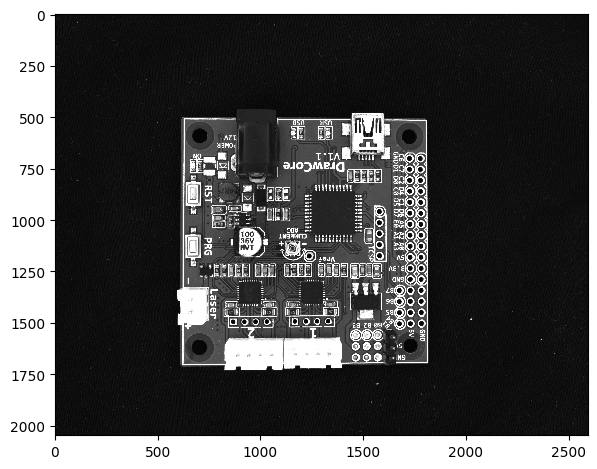

In [3]:
imshow(template_masked_original)

## Prepare masks


In [4]:
mask_chunks = []  # Image chunk with expected text
mask_values = []  # Cut information
mask_meta = []  # Expected perfect text, rotation and result of inspection

for f in os.listdir(template_masked_dir):
    template_masked = cv.cvtColor(
        cv.imread(f"{template_masked_dir}/{f}"),
        cv.COLOR_BGR2RGB,
    )
    color = get_target_color(f)
    text = get_target_text(f)
    color, rotation, expectation = extract_meta[color]
    chunks, values = extract(template_masked_original, color, template_masked)
    mask_values.extend(values)
    mask_chunks.append(chunks)
    mask_meta.append((text, rotation, expectation))

## Load all images


In [5]:
all_images = []  # [im1, im2, ...]
all_chunks = []  # [[chunk1, chunk2, ...], ...]
all_meta = []  # [[(txt1, rot1, res1), (txt2, rot2, res2), ...], ...]
all_values = []  # [[val1, val2, ...], ...]

for target in targets:
    # Walk different camera setups
    print(f"Processing: {target}")
    for f in os.listdir(f"{source_folder}/{target}"):
        # Load each image to perform inspection on
        tested_image = cv.cvtColor(
            cv.imread(f"{source_folder}/{target}/{f}"),
            cv.COLOR_BGR2GRAY,
        )
        # Perform component location extraction
        im = align(tested_image, template_masked_original)
        all_images.append(im)

        chunks = []
        values = []
        meta = []
        for mask_v, mask_m in zip(mask_values, mask_meta):
            chunk = cut(im, mask_v)
            chunks.append(chunk)
            values.append(mask_v)
            meta.append(mask_m)

        all_chunks.append(chunks)
        all_values.append(values)
        all_meta.append(meta)

Processing: 34_drawcore_uc_16mm_f8_6448
Processing: 35_drawcore_uc_16mm_f8_5270
Processing: 36_drawcore_uc_16mm_f8_7604


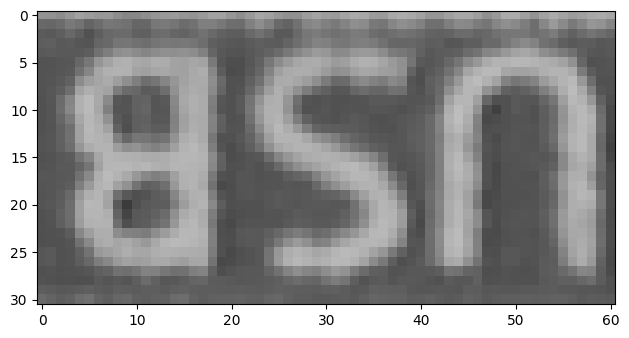

In [6]:
imshow(all_chunks[21][15])

In [46]:
def image_to_square_box(im: np.ndarray):
    s = max(im.shape)
    box = np.zeros((s, s))
    r = int(s / 2) - int(im.shape[0] / 2)
    c = int(s / 2) - int(im.shape[1] / 2)
    box[r : r + im.shape[0], c : c + im.shape[1]] = im
    im = box.astype(np.uint8)
    return im


def trim_zero_rows_and_cols(arr):
    # Find the index of the first non-zero element in each row
    row_sums = np.sum(arr != 0, axis=1)
    first_nonzero_row = np.argmax(row_sums > 0)

    # Find the index of the first non-zero element in each column
    col_sums = np.sum(arr != 0, axis=0)
    first_nonzero_col = np.argmax(col_sums > 0)

    # Find the index of the last non-zero element in each row
    last_nonzero_row = arr.shape[0] - 1 - np.argmax(row_sums[::-1] > 0)

    # Find the index of the last non-zero element in each column
    last_nonzero_col = arr.shape[1] - 1 - np.argmax(col_sums[::-1] > 0)

    # Slice the array to keep rows and columns between the first and last non-zero indices
    trimmed_arr = arr[
        first_nonzero_row : last_nonzero_row + 1,
        first_nonzero_col : last_nonzero_col + 1,
    ]

    return trimmed_arr


def pad_array(arr):
    # Pad 2 rows of zeros at the top and bottom
    padded_arr = np.pad(arr, ((1, 1), (1, 1)), mode="constant", constant_values=0)
    return padded_arr


def tesseract_ocr_inspection(im: np.ndarray, txt: str):
    im = tesseract_image_normalization(im)
    result = pytesseract.image_to_string(im)
    result = result.strip().lower().replace(" ", "")
    txt = txt.strip().lower().replace(" ", "")
    return (txt in result), result


def tesseract_image_normalization(im: np.ndarray):
    # Preprocess image for tesseract
    _, im = cv.threshold(im, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    r = im.shape[0] + 200
    c = im.shape[1] + 200
    box = np.zeros((r, c))
    r = int(r / 2) - int(im.shape[0] / 2)
    c = int(c / 2) - int(im.shape[1] / 2)
    box[r : r + im.shape[0], c : c + im.shape[1]] = im
    im = box.astype(np.uint8)
    im = 255 - im
    im = cv.cvtColor(
        im,
        cv.COLOR_GRAY2RGB,
    )

    return im


def doctr_ocr_inspection(im: np.ndarray, model_instance, txt: str):
    im = doctr_image_normalization(im)
    im = np.expand_dims(1 - (im / 255), 0)
    im = tf.convert_to_tensor(im)
    result = model_instance(im)
    txt = txt.strip().lower().replace(" ", "")
    for pred in result["preds"]:
        found_text, _ = pred
        found_text = found_text.strip().lower().replace(" ", "")
        if txt in found_text:
            return True, result
    return False, result


def doctr_image_normalization(im: np.ndarray, input_shape=(32, 128)):
    # Apply first threshold to remove background and trim empty space
    _, im = cv.threshold(im, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    im = trim_zero_rows_and_cols(im)
    # im = pad_array(im)

    if 1.2 > im.shape[0] / im.shape[1] > 0.8:  # Arbitrary selected
        # Image seems to be square, do not resize to input size (but to max allowed by input), but put
        # into box in center to fit input size of model
        k = input_shape[0] / im.shape[0]
        im = cv.resize(im, (0, 0), fx=k, fy=k)
        r, c = input_shape
        box = np.zeros(input_shape)
        r = int(r / 2) - int(im.shape[0] / 2)
        c = int(c / 2) - int(im.shape[1] / 2)
        box[r : r + im.shape[0], c : c + im.shape[1]] = im
        im = box.astype(np.uint8)
    else:
        if im.shape[0] / im.shape[1] > 1.2:  # Arbitrary selected
            # Rotate vertical images
            im = imutils.rotate(im, 90)
        im = cv.resize(im, (input_shape[1], input_shape[0]))

    im = cv.cvtColor(
        im,
        cv.COLOR_GRAY2RGB,
    )
    return im

In [47]:
tests = []
results = []
for i, (chunks, meta) in enumerate(zip(all_chunks, all_meta)):
    print(f"Processing image: {i} / {len(all_images)}")
    success = 0
    fail = 0
    for chunk_im, chunk_meta in zip(chunks, meta):
        text, rotation, expectation = chunk_meta
        chunk_im = image_to_square_box(chunk_im)
        chunk_im = imutils.rotate(chunk_im, rotation)
        chunk_im = trim_zero_rows_and_cols(chunk_im)

        # test, result = tesseract_ocr_inspection(chunk_im,  text)
        test, result = doctr_ocr_inspection(chunk_im, model, text)

        if test == expectation:
            success += 1
        else:
            fail += 1

        tests.append((test, expectation))
        results.append(result)
    print(f"Result: success {success}/{success+fail}")

Processing image: 0 / 90
Result: success 14/18
Processing image: 1 / 90
Result: success 14/18
Processing image: 2 / 90
Result: success 11/18
Processing image: 3 / 90
Result: success 12/18
Processing image: 4 / 90
Result: success 14/18
Processing image: 5 / 90
Result: success 14/18
Processing image: 6 / 90
Result: success 13/18
Processing image: 7 / 90
Result: success 13/18
Processing image: 8 / 90
Result: success 13/18
Processing image: 9 / 90
Result: success 15/18
Processing image: 10 / 90
Result: success 14/18
Processing image: 11 / 90
Result: success 12/18
Processing image: 12 / 90
Result: success 14/18
Processing image: 13 / 90
Result: success 11/18
Processing image: 14 / 90
Result: success 17/18
Processing image: 15 / 90
Result: success 15/18
Processing image: 16 / 90
Result: success 14/18
Processing image: 17 / 90
Result: success 12/18
Processing image: 18 / 90
Result: success 12/18
Processing image: 19 / 90
Result: success 14/18
Processing image: 20 / 90
Result: success 16/18
Pr

In [51]:
import pickle

In [54]:
# pickle.dump(tests, open('tests.pickle', 'wb'))

In [55]:
# pickle.dump(results, open('results.pickle', 'wb'))

In [ ]:
pickle.load(open("tests.pickle", "rb"))